In [0]:
import torch
import torch.nn
import torch.optim
import torchvision.datasets
import torchvision.transforms
import torch.utils.data

In [0]:
torch.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [0]:
BATCH_SIZE = 32
EPOCHS = 10

# TODO

* Early stopping at minimum validation loss
* Plot with loss curves for autoencoder with different bottleneck sizes
* Maybe regularization methods at transfer-learning step

# Exercise 1: Convolutional Autoencoder

Steps:
1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.
2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).
3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.
4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.
5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.
Generate 5 new images by injecting random values as input to the decoder. Show them.


## Module definition

Our autoencoder will be defined by the `ConvolutionalAutoencoder` class which uses a `ConvolutionalEncoder` object to encode followed a `ConvolutionalDecoder` object to decode. The `ConvolutionalEncoder` and `ConvolutionalDecoder` classes make use of `n_blocks` `ConvolutionalBlock`s or `DeconvolutionalBlock`s which are composed of `layer_per_block` convolution layers with the same number of filters.

The dimensionality is reduced by applying 2-factor spatial downsampling at each block. The number of filters is doubled for each subsequent block. The decoder makes the exact oposite process.

The final layer uses a tanh activation.

Very similar to the `ConvolutionalAutoencoder`, there is the `ConvolutionalAutoencoderReducedLatentDim` class which includes 2 fully-connected layers between the encoder and decoder. The first one projects from the encoder's feature maps to a vector of `latent_dimensionality` dimensions, the second one does the opposite.

In [0]:
# %load models.py
import torch
import torch.nn


class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self, n_blocks, downsampling_method, upsampling_method,
                 layers_per_block=2):
        super().__init__()
        self.n_blocks = n_blocks
        self.downsampling_method = downsampling_method
        self.upsampling_method = upsampling_method

        self.encoder = ConvolutionalEncoder(n_blocks, downsampling_method,
                                            layers_per_block=layers_per_block)
        self.decoder = ConvolutionalDecoder(n_blocks, upsampling_method,
                                            self.encoder.output_channels,
                                            layers_per_block)

    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction


class ConvolutionalAutoencoderReducedLatentDim(torch.nn.Module):

    def __init__(self, input_shape, n_blocks, downsampling_method, upsampling_method,
                 layers_per_block=2, latent_dimensionality=50):
        super().__init__()
        self.n_blocks = n_blocks
        self.downsampling_method = downsampling_method
        self.upsampling_method = upsampling_method
        self.latent_dimensionality = latent_dimensionality

        # Encoder: Convolutional blocks + Linear
        self.convolutional_encoder = ConvolutionalEncoder(
            n_blocks, downsampling_method, layers_per_block=layers_per_block)
        self.encoder_output_shape = (self.convolutional_encoder.init_filters * 2 ** (n_blocks - 1),
                                     input_shape[0] // 2 ** n_blocks,
                                     input_shape[1] // 2 ** n_blocks)
        self.encoder = torch.nn.Sequential(
            self.convolutional_encoder,
            torch.nn.Flatten(),
            torch.nn.Linear(self.encoder_output_shape[0] * self.encoder_output_shape[1] * self.encoder_output_shape[2],
                            latent_dimensionality),
            torch.nn.ReLU()
        )

        # Decoder: Linear + Convolutional blocks
        self.linear_decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dimensionality,
                            self.encoder_output_shape[0] * self.encoder_output_shape[1] * self.encoder_output_shape[2]),
            torch.nn.ReLU()
        )
        self.convolutional_decoder = ConvolutionalDecoder(
            n_blocks, upsampling_method,
            self.convolutional_encoder.output_channels, layers_per_block)

    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.convolutional_decoder(
            self.linear_decoder(code).view((-1,) + self.encoder_output_shape))
        return reconstruction


class ConvolutionalEncoder(torch.nn.Module):
    DOWNSAMPLING_METHODS = ["max-pooling", "avg-pooling", "stride-2"]

    def __init__(self, n_blocks, downsampling_method, init_filters=16,
                 layers_per_block=2, kernel_size=5, input_channels=1):
        super().__init__()
        self.n_blocks = n_blocks
        assert downsampling_method in self.DOWNSAMPLING_METHODS
        self.downsampling_method = downsampling_method
        self.layers_per_block = layers_per_block
        self.init_filters = init_filters
        self.kernel_size = kernel_size
        self.input_channels = input_channels

        layers = []

        # First layer so we have <input_channels> channels.
        n_filters = init_filters
        layers.append(
            ConvolutionalBlock(input_channels, n_filters, kernel_size, 1))

        # Encoding blocks.
        input_channels = n_filters
        for _ in range(n_blocks):
            if downsampling_method == "max-pooling":
                # Convolutional block + max pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size,
                                       layers_per_block),
                    torch.nn.MaxPool2d(2)
                )
            elif downsampling_method == "avg-pooling":
                # Convolutional block + average pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size,
                                       layers_per_block),
                    torch.nn.AvgPool2d(2)
                )
            else:
                # Stride-2 convolution.
                conv_block = ConvolutionalBlock(input_channels, n_filters,
                                                kernel_size,
                                                layers_per_block,
                                                last_stride=2)
            layers.append(conv_block)
            # Double the number of filters.
            input_channels = n_filters
            n_filters = 2 * n_filters

        self.encoder = torch.nn.Sequential(*layers)
        self.output_channels = input_channels

    def forward(self, x):
        return self.encoder(x)


class ConvolutionalDecoder(torch.nn.Module):
    UPSAMPLING_METHODS = ["transposed", "bilinear", "bicubic", "nearest"]

    def __init__(self, n_blocks, upsampling_method, input_channels,
                 layers_per_block=2, kernel_size=5, output_channels=1):
        super().__init__()
        self.n_blocks = n_blocks
        assert upsampling_method in self.UPSAMPLING_METHODS
        self.upsampling_method = upsampling_method
        self.layers_per_block = layers_per_block
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.output_channels = output_channels

        layers = []

        # Decoding blocks.
        n_filters = input_channels
        for _ in range(n_blocks):
            if upsampling_method == "transposed":
                # Deconvolutional block
                conv_block = DeconvolutionalBlock(input_channels, n_filters,
                                                  kernel_size, layers_per_block,
                                                  stride=2)
            else:
                # Upsampling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size,
                                       layers_per_block),
                    torch.nn.Upsample(scale_factor=2, mode=upsampling_method)
                )
            layers.append(conv_block)
            # Half the number of filters.
            input_channels = n_filters
            n_filters = n_filters // 2

        # Last layer so we have <output_channels> channel.
        layers.append(torch.nn.Conv2d(input_channels, output_channels, kernel_size,
                                      padding=kernel_size // 2))
        layers.append(torch.nn.Tanh())

        self.decoder = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class ConvolutionalBlock(torch.nn.Module):
    """

    Applies n_layers convolutional layers with the same number of
    filters and filter sizes with ReLU activations
    keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers,
                 last_stride=1):
        super().__init__()
        layers = []
        padding = kernel_size // 2  # To keep the same size.

        for i in range(n_layers):
            if i == 0:  # First layer with correct input channels.
                layers.append(torch.nn.Conv2d(input_channels, n_filters,
                                              kernel_size, padding=padding))
            elif 0 < i < n_layers:  # Intermediate layers.
                layers.append(torch.nn.Conv2d(n_filters, n_filters,
                                              kernel_size, padding=padding))
            else:  # Last layer with stride.
                layers.append(torch.nn.Conv2d(n_filters, n_filters,
                                              kernel_size, last_stride, padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class DeconvolutionalBlock(torch.nn.Module):
    """

    Applies a transposed convolution followed by n_layers-1 convolutional
    layers with the same number of filters and filter sizes with ReLU
    activations keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers, stride):
        super().__init__()
        layers = []
        padding = kernel_size // 2

        # Transposed convolution layer.
        layers.append(torch.nn.ConvTranspose2d(input_channels, n_filters,
                                               kernel_size, stride, padding, 1))
        layers.append(torch.nn.ReLU())

        for _ in range(n_layers - 1):
            layers.append(torch.nn.Conv2d(n_filters, n_filters, kernel_size,
                                          padding=padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

To do a quick test, we will pass a random image and check if the output is of the same size as the input.

In [0]:
image = torch.randn((10, 1, 128, 128))
autoencoder = ConvolutionalAutoencoderReducedLatentDim(input_shape=(128, 128),
                                                       n_blocks=2,
                                                       downsampling_method='max-pooling',
                                                       upsampling_method='nearest',
                                                       layers_per_block=2,
                                                       latent_dimensionality=50)
output = autoencoder(image)
assert output.shape == (10, 1, 128, 128)

## Dataset

We split the training set and normalize the input images with mean and variance of the training set found on the internet.

In [0]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Mean and std from internet...
])

In [0]:
mnist = torchvision.datasets.MNIST('mnist_dataset', train=True, transform=transform, download=True)

In [0]:
dataset_len = len(mnist)

In [9]:
dataset_len * 0.95

57000.0

In [0]:
mnist_train, mnist_val = torch.utils.data.random_split(mnist, [57000, dataset_len - 57000])

In [0]:
train_dataloader = torch.utils.data.DataLoader(mnist_train,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=4)

In [0]:
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=BATCH_SIZE)

To create our autoencoder we need to know the size of our images.

In [13]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

We will use **2 blocks of 2 convolutional layers** on each block (each in the encoder and decoder), using **max-pooling** for downsampling and **nearest-neighbour** for upsampling.

In [0]:
autoencoder = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=50
).to(device)

We use the mean square error as our loss function and Adam as our optimization algorithm with a learning rate of 0.001.  
We use 'sum' as reduction to compute the image reconstruction error instead of the pixel reconstruction error.

In [0]:
mse = torch.nn.MSELoss(reduction='sum')
adam = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

Define our `train` function that will be called at each epoch.

In [0]:
def train(model, dataloader, criterion, optimizer, epoch, loss_history):
    for i, batch in enumerate(dataloader):
        images = batch[0].to(device)
        optimizer.zero_grad()
        reconstructed = model(images)
        # Divide by batch size to compute mean image reconstruction error.
        loss = criterion(reconstructed, images) / images.shape[0]
        loss.backward()   # Backprop.
        optimizer.step()  # Parameter updates.

        loss_history.append(loss.item())
        if i % 100 == 0:
            print('[%d, %d] loss: %.3f' % (epoch + 1, i, loss.item()))

Very similar to the `train` function, we define our `test` function to validate. In this case we don't backpropagate and update our parameters.

In [0]:
def test(model, dataloader, criterion, epoch, loss_history):
    loss = 0
    total = 0
    for batch in dataloader:
        images = batch[0].to(device)
        reconstructed = model(images)
        loss += criterion(reconstructed, images).item()
        total += images.shape[0]

    mean_loss = loss / total
    loss_history.append(mean_loss)  
    print('[%d, validation] loss: %.3f' % (epoch + 1, mean_loss))

This is our training loop. Firstly, we call the `test` function so our validation loss curve includes the initial/untrained "behaviour".

In [18]:
training_loss = []    #
validation_loss = []  # Here we save the training process.

for epoch in range(EPOCHS):
    autoencoder.eval()
    with torch.no_grad():
        test(autoencoder, val_dataloader, mse, epoch, validation_loss)
    autoencoder.train()
    train(autoencoder, train_dataloader, mse, adam, epoch, training_loss)

autoencoder.eval()
with torch.no_grad():
    test(autoencoder, val_dataloader, mse, epoch, validation_loss)

[1, validation] loss: 796.878
[1, 0] loss: 797.393
[1, 100] loss: 523.624
[1, 200] loss: 452.694
[1, 300] loss: 387.181
[1, 400] loss: 338.360
[1, 500] loss: 337.066
[1, 600] loss: 348.504
[1, 700] loss: 297.391
[1, 800] loss: 324.090
[1, 900] loss: 273.810
[1, 1000] loss: 318.508
[1, 1100] loss: 294.428
[1, 1200] loss: 299.358
[1, 1300] loss: 302.557
[1, 1400] loss: 325.213
[1, 1500] loss: 316.487
[1, 1600] loss: 295.287
[1, 1700] loss: 310.023
[2, validation] loss: 304.777
[2, 0] loss: 300.750
[2, 100] loss: 274.208
[2, 200] loss: 261.670
[2, 300] loss: 286.985
[2, 400] loss: 297.343
[2, 500] loss: 271.363
[2, 600] loss: 321.058
[2, 700] loss: 265.856
[2, 800] loss: 287.655
[2, 900] loss: 235.708
[2, 1000] loss: 264.461
[2, 1100] loss: 281.901
[2, 1200] loss: 313.849
[2, 1300] loss: 344.375
[2, 1400] loss: 279.689
[2, 1500] loss: 291.753
[2, 1600] loss: 289.783
[2, 1700] loss: 279.073
[3, validation] loss: 298.107
[3, 0] loss: 298.327
[3, 100] loss: 299.820
[3, 200] loss: 333.457
[3,

In [0]:
import matplotlib.pyplot as plt
import numpy as np

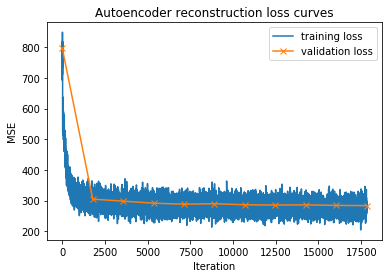

In [20]:
plt.title('Autoencoder reconstruction loss curves')
plt.plot(training_loss, label='training loss')
plt.plot(np.linspace(0, len(training_loss), len(validation_loss)), validation_loss, '-x', label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend();

We can see that the loss quickly reduces and then it doesn't improve much. The validation curve is similar to the training one, so we can say it doesn't overfit the training data.

In log-scale:

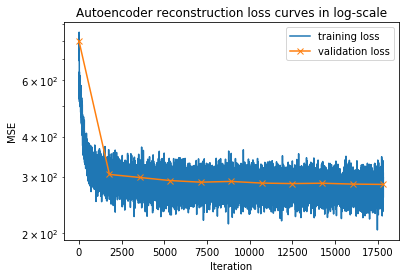

In [21]:
plt.title('Autoencoder reconstruction loss curves in log-scale')
plt.yscale('log')
plt.plot(training_loss, label='training loss')
plt.plot(np.linspace(0, len(training_loss), len(validation_loss)), validation_loss, '-x', label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend();

Now we'll try to reconstruct a image from the test dataset.

In [0]:
mnist_test = torchvision.datasets.MNIST('mnist_dataset', train=False, transform=transform)

In [0]:
reconstructed = autoencoder(mnist_test[6][0].to(device).unsqueeze(0))

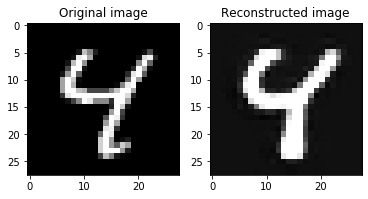

In [24]:
plt.subplot(121).set_title('Original image')
plt.imshow(mnist_test[6][0][0], cmap='gray')
plt.subplot(122).set_title('Reconstructed image')
plt.imshow(reconstructed[0][0].detach().cpu().numpy(), cmap='gray');

We can see some information is loss, but the reconstruction is pretty accurate.

# Exercise 2: Transfer Learning

## Steps:

1. Select a subset of 100 images and their associated labels from the MNIST training data.
2. Select one of the previously trained autoencoders.
3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
3. Pretraining: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
4. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
5. From scratch: train the model on the 100 samples without reusing the decoder weights at all.
6. Show the accuracy of the four models on the MNIST test set in a table.


## Pretraining

The number of outputs need to be 10 as we have 10 classes, and 50 as input because we will use the encoder with a latent dimensionality of 50.

We don't need to define a softmax layer, as the `CrossEntropyLoss` class internally applies it.

In [0]:
classifier = torch.nn.Linear(50, 10).to(device)

We use the cross-entropy as our loss function and Adam as our optimization algorithm with a learning rate of 0.01.

In [0]:
cross_entropy = torch.nn.CrossEntropyLoss()
classifier_adam = torch.optim.Adam(classifier.parameters(), lr=0.01)

We create a subset daaset using the pytorch's `Subset` class with the first 100 samples from the training split.

In [0]:
training_subset = torch.utils.data.Subset(mnist_train, range(100))
subset_dataloader = torch.utils.data.DataLoader(training_subset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=4)

Define our `classification_train` function that will be called at each epoch. The funciton takes the classifier network as well as the encoder network. It first projects the input image to the latent space and then applies the classification layer.

The output of the encoder is detached so the gradients are not computed (because we dont need them).

In [0]:
def classification_train(classifier, encoder, dataloader, criterion, optimizer, epoch, loss_history):
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device, torch.long)
        optimizer.zero_grad()
        # To latent space.
        codes = encoder(images).detach()
        # Classify from latent space.
        outputs = classifier(codes)
        loss = criterion(outputs, labels)
        loss.backward()   # Backprop.
        optimizer.step()  # Parameter updates.

        loss_history.append(loss.item())
        print('[%d, %d] loss: %.3f' % (epoch + 1, i, loss.item()))

Very similar to the `classification_train` function, we define our `classification_test` function to validate. In this case we don't backpropagate and update our parameters. We also compute the accuracy by summing all the correct predictions and dividing by the total number of images.

In [0]:
def classification_test(classifier, encoder, dataloader, criterion, epoch, loss_history):
    loss = 0
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device, torch.long)
        codes = encoder(images)
        outputs = classifier(codes)
        loss += criterion(outputs, labels).item()
        # Compute average accuracy.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    mean_loss = loss / (i + 1)
    loss_history.append(mean_loss)  
    print('[%d, validation] loss: %.3f accuracy: %.3f' % (epoch + 1, mean_loss, 100 * correct / total))

We pass the `encoder` submodule of the `autoencoder` object as the `encoder` parameter of the above-defined functions.

In [30]:
training_loss = []    #
validation_loss = []  # Here we save the training process.

for epoch in range(EPOCHS):
    classifier.eval()
    with torch.no_grad():
        classification_test(classifier, autoencoder.encoder, val_dataloader, cross_entropy, epoch, validation_loss)
    classifier.train()
    classification_train(classifier, autoencoder.encoder, subset_dataloader, cross_entropy, classifier_adam, epoch, training_loss)

classifier.eval()
with torch.no_grad():
    classification_test(classifier, autoencoder.encoder, val_dataloader, cross_entropy, epoch, validation_loss)

[1, validation] loss: 2.433 accuracy: 9.367
[1, 0] loss: 2.376
[1, 1] loss: 2.264
[1, 2] loss: 2.405
[1, 3] loss: 2.197
[2, validation] loss: 2.251 accuracy: 23.367
[2, 0] loss: 2.173
[2, 1] loss: 2.141
[2, 2] loss: 2.161
[2, 3] loss: 1.979
[3, validation] loss: 2.196 accuracy: 29.533
[3, 0] loss: 2.077
[3, 1] loss: 2.174
[3, 2] loss: 1.986
[3, 3] loss: 1.825
[4, validation] loss: 2.145 accuracy: 34.700
[4, 0] loss: 2.137
[4, 1] loss: 1.865
[4, 2] loss: 2.012
[4, 3] loss: 1.572
[5, validation] loss: 2.086 accuracy: 41.033
[5, 0] loss: 1.815
[5, 1] loss: 2.033
[5, 2] loss: 1.860
[5, 3] loss: 2.446
[6, validation] loss: 2.028 accuracy: 40.867
[6, 0] loss: 1.975
[6, 1] loss: 1.705
[6, 2] loss: 1.884
[6, 3] loss: 1.699
[7, validation] loss: 1.943 accuracy: 42.800
[7, 0] loss: 1.835
[7, 1] loss: 1.708
[7, 2] loss: 1.759
[7, 3] loss: 1.918
[8, validation] loss: 1.872 accuracy: 44.833
[8, 0] loss: 1.790
[8, 1] loss: 1.607
[8, 2] loss: 1.749
[8, 3] loss: 1.315
[9, validation] loss: 1.813 accur

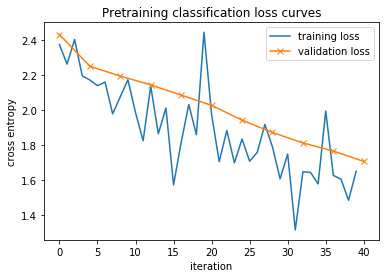

In [31]:
plt.title('Pretraining classification loss curves')
plt.plot(training_loss, label='training loss')
plt.plot(np.linspace(0, len(training_loss), len(validation_loss)), validation_loss, '-x', label='validation loss')
plt.xlabel('iteration')
plt.ylabel('cross entropy')
plt.legend();

In [0]:
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE)

In [33]:
classification_test(classifier, autoencoder.encoder, test_dataloader, cross_entropy, epoch, [])

[10, validation] loss: 1.707 accuracy: 60.520


We obtain an accuracy of 65.6% on our test data.

## Fine-tuning

We modify the `classification_train` function to accept the encoder optimizer as a parameter and updates both the encoder and classification networks.

The `classification_test` function doesn't need to be modified.

In [0]:
def classification_train(classifier, encoder, dataloader, criterion, classifier_optimizer, encoder_optimizer, epoch, loss_history):
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device, torch.long)
        encoder_optimizer.zero_grad()
        classifier_optimizer.zero_grad()
        # To latent space.
        codes = encoder(images)
        # Classify from latent space.
        outputs = classifier(codes)
        loss = criterion(outputs, labels)
        loss.backward()              # Backprop.
        encoder_optimizer.step()     # Update encoder parameters.
        classifier_optimizer.step()  # Update classifier parameters.

        loss_history.append(loss.item())
        print('[%d, %d] loss: %.3f' % (epoch + 1, i, loss.item()))

We define a new Adam optimizer for the encoder network with a small learning rate of 0.0001. The classification network optimizer is reused.

In [0]:
encoder_adam = torch.optim.Adam(autoencoder.encoder.parameters(), lr=0.0001)

Note that we don't redefine the `training_loss` and `validation_loss` list, so they will have the values of the pretraining stage too.

In [36]:
for epoch in range(20):
    classifier.eval()
    autoencoder.encoder.eval()
    with torch.no_grad():
        classification_test(classifier, autoencoder.encoder, val_dataloader, cross_entropy, epoch, validation_loss)
    classifier.train()
    autoencoder.encoder.train()
    classification_train(classifier, autoencoder.encoder, subset_dataloader,
                         cross_entropy, classifier_adam, encoder_adam, epoch, training_loss)

classifier.eval()
autoencoder.encoder.eval()
with torch.no_grad():
    classification_test(classifier, autoencoder.encoder, val_dataloader, cross_entropy, epoch, validation_loss)

[1, validation] loss: 1.707 accuracy: 59.533
[1, 0] loss: 1.509
[1, 1] loss: 1.497
[1, 2] loss: 1.526
[1, 3] loss: 1.356
[2, validation] loss: 1.603 accuracy: 66.000
[2, 0] loss: 1.395
[2, 1] loss: 1.383
[2, 2] loss: 1.375
[2, 3] loss: 1.555
[3, validation] loss: 1.512 accuracy: 65.567
[3, 0] loss: 1.324
[3, 1] loss: 1.270
[3, 2] loss: 1.294
[3, 3] loss: 1.212
[4, validation] loss: 1.428 accuracy: 65.933
[4, 0] loss: 1.340
[4, 1] loss: 1.196
[4, 2] loss: 1.065
[4, 3] loss: 0.888
[5, validation] loss: 1.345 accuracy: 69.233
[5, 0] loss: 1.033
[5, 1] loss: 1.161
[5, 2] loss: 1.047
[5, 3] loss: 1.194
[6, validation] loss: 1.254 accuracy: 68.833
[6, 0] loss: 1.116
[6, 1] loss: 0.955
[6, 2] loss: 0.835
[6, 3] loss: 0.965
[7, validation] loss: 1.151 accuracy: 71.400
[7, 0] loss: 0.919
[7, 1] loss: 0.894
[7, 2] loss: 0.761
[7, 3] loss: 1.025
[8, validation] loss: 1.053 accuracy: 77.167
[8, 0] loss: 0.716
[8, 1] loss: 0.864
[8, 2] loss: 0.806
[8, 3] loss: 0.469
[9, validation] loss: 0.963 accu

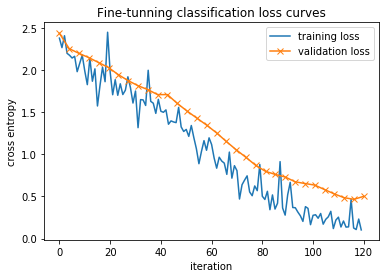

In [37]:
plt.title('Fine-tunning classification loss curves')
plt.plot(training_loss, label='training loss')
plt.plot(np.linspace(0, len(training_loss), len(validation_loss)), validation_loss, '-x', label='validation loss')
plt.xlabel('iteration')
plt.ylabel('cross entropy')
plt.legend();